Learning to Learn - John Tomlinson, Ahan Maurya, Dr. Jing Wang

First we need to import the modules we created for this notebook

In [1]:
import meta_network
import original_network
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Reload to pick up on-disk changes to original_network
import importlib
importlib.reload(original_network)
importlib.reload(meta_network)

<module 'meta_network' from 'c:\\Users\\bobtt\\OneDrive\\Desktop\\Documents\\JackCS\\learning-to-learn\\cartpole-implementation\\meta_network.py'>

We will start by initializing both of our networks

In [3]:
cartpole_network, cartpole_target_network,memory, optimizer, device, env = original_network.build_model()

Now lets build a function to graph our reward over time

In [4]:
def plot_rewards(reward_list):
    plt.plot(reward_list)
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.title('Reward over Time')
    plt.scatter(range(len(reward_list)), reward_list, marker='o', color='red')
    plt.show()


Lets make a training loop to get our baseline performance for our model wihtout the meta learning

In [5]:
NUM_EPISODES = 400
TARGET_UPDATE = 10

In [ ]:
def training_loop(episodes, record_states=False, epsilon_start=1.0, epsilon_end=0.05, epsilon_decay=0.995):
    total_reward_list = []
    episodes_states = []  # list of arrays: each is (T, 4) for CartPole
    epsilon = epsilon_start
    best_reward = 0
   
    for episode in range(episodes):
        state, _ = env.reset()
        processed_state = original_network.process_state(state)
        done = False
        total_reward = 0
       
        episode_states = []

        frames = []
        while not done:
            action = original_network.select_action(processed_state, cartpole_network, device, epsilon, env)
            next_state, reward, terminated, truncated, _ = env.step(action)
            if (total_reward > 300):
                print(next_state)
                print(env.observation_space.high)
            done = terminated or truncated
            save_state = next_state
            processed_next_state = original_network.process_state(next_state)
            memory.push(processed_state, action, reward, processed_next_state, done)
           
            if record_states:
                episode_states.append(save_state)
                
            
           
            processed_state = processed_next_state
            total_reward += reward
           
            if episode > 0:
                frame = env.render()
                frames.append(frame)


        original_network.optimize_model(cartpole_network, cartpole_target_network, memory, optimizer, device)


        if episode % TARGET_UPDATE == 0:
            cartpole_target_network.load_state_dict(cartpole_network.state_dict())
       
        if episode % 1 == 0:
            print(f"Episode {episode+1}/{episodes}, Total Reward: {total_reward}")
        total_reward_list.append(total_reward)
       
        if record_states and episode_states:
            episodes_states.append(np.array(episode_states))


        best_reward = original_network.save_best_model(episode, best_reward, total_reward, frames)
        epsilon = max(epsilon_end, epsilon * epsilon_decay)  # decay exploration rate
   
    if record_states:
        return total_reward_list, episodes_states
    else:
        return total_reward_list


In [9]:
x_values = []
for i in episodes_states:
    for j in i:
        x_values.append(j[2])

max(x_values)

np.float32(0.25481275)

[-0.04357908 -0.15334484 -0.02934907  0.28641242]
[4.8               inf 0.41887903        inf]
[-0.04664597 -0.3480362  -0.02362083  0.5696963 ]
[4.8               inf 0.41887903        inf]
[-0.0536067 -0.542819  -0.0122269  0.8548452]
[4.8               inf 0.41887903        inf]
[-0.06446308 -0.7377722   0.00487     1.1436585 ]
[4.8               inf 0.41887903        inf]
[-0.07921852 -0.9329575   0.02774318  1.4378647 ]
[4.8               inf 0.41887903        inf]
[-0.09787767 -1.1284102   0.05650047  1.7390863 ]
[4.8               inf 0.41887903        inf]
[-0.12044588 -1.3241284   0.0912822   2.0487976 ]
[4.8               inf 0.41887903        inf]
[-0.14692844 -1.5200598   0.13225815  2.3682706 ]
[4.8               inf 0.41887903        inf]
[-0.17732964 -1.7160854   0.17962356  2.6985118 ]
[4.8               inf 0.41887903        inf]
[-0.21165134 -1.9120016   0.23359379  3.0401838 ]
[4.8               inf 0.41887903        inf]
Episode 1/10, Total Reward: 10.0
[-0.0373733

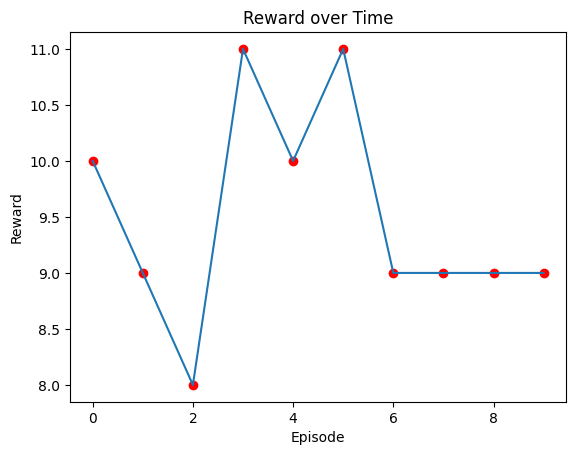

In [7]:
rewards, episodes_states = training_loop(10, record_states=True)
plot_rewards(rewards)


In [8]:
def compute_state_stats(episodes_states):
    stats = {
        'best_x': [],         
        'avg_x': [],           
        'best_angle': [],      
        'avg_angle': [],       
        'best_x_vel': [],      
        'avg_x_vel': [],       
        'best_angle_vel': [],  
        'avg_angle_vel': []    
    }
   
    for episode_states in episodes_states:

        stats['best_x'].append(np.min(np.abs(episode_states[:, 0])))
        stats['avg_x'].append(np.mean(np.abs(episode_states[:, 0])))

        stats['best_angle'].append(np.min(np.abs(episode_states[:, 2])))
        stats['avg_angle'].append(np.mean(np.abs(episode_states[:, 2])))

        stats['best_x_vel'].append(np.min(np.abs(episode_states[:, 1])))
        stats['avg_x_vel'].append(np.mean(np.abs(episode_states[:, 1])))
        stats['best_angle_vel'].append(np.min(np.abs(episode_states[:, 3])))
        
        stats['avg_angle_vel'].append(np.mean(np.abs(episode_states[:, 3])))
   
    return {k: np.array(v) for k, v in stats.items()}



def plot_state_metric(metric_values, metric_name, color='steelblue'):


    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(metric_values, color=color, linewidth=1.5, label='Metric')
    ax.scatter(range(len(metric_values)), metric_values, marker='o', color=color, s=20, alpha=0.6)
    ax.set_xlabel('Episode')
    ax.set_ylabel(metric_name)
    ax.set_title(f'{metric_name} over Time')
    ax.grid(True, alpha=0.3)
    ax.legend()
    plt.tight_layout()
    plt.show()


def plot_state_metrics_all(state_stats):

    metrics = [
        ('best_x', 'Min |Cart Position|'),
        ('avg_x', 'Avg |Cart Position|'),
        ('best_angle', 'Min |Pole Angle|'),
        ('avg_angle', 'Avg |Pole Angle|'),

        ('best_x_vel', 'Min |Cart Velocity|'),
        ('avg_x_vel', 'Avg |Cart Velocity|'),
        ('best_angle_vel', 'Min |Pole Velocity|'),
        ('avg_angle_vel', 'Avg |Pole Velocity|')
    ]
   
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.flatten()
   
    for idx, (key, title) in enumerate(metrics):
        ax = axes[idx]
        values = state_stats[key]

        ax.plot(values, color='steelblue', linewidth=1.5)
        ax.scatter(range(len(values)), values, marker='o', color='steelblue', s=15, alpha=0.6)

        ax.set_xlabel('Episode')
        ax.set_ylabel(title)

        ax.set_title(title)

        ax.grid(True, alpha=0.3)
   
    plt.tight_layout()
    plt.show()

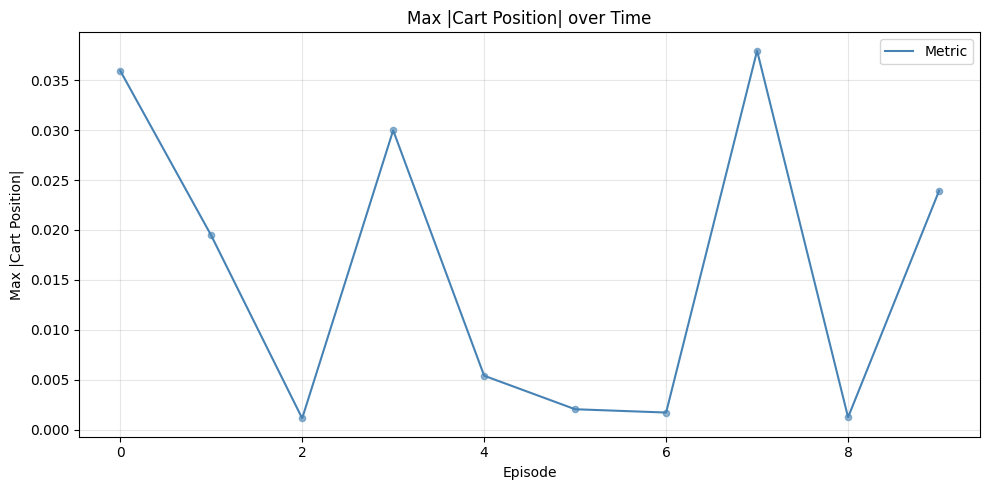

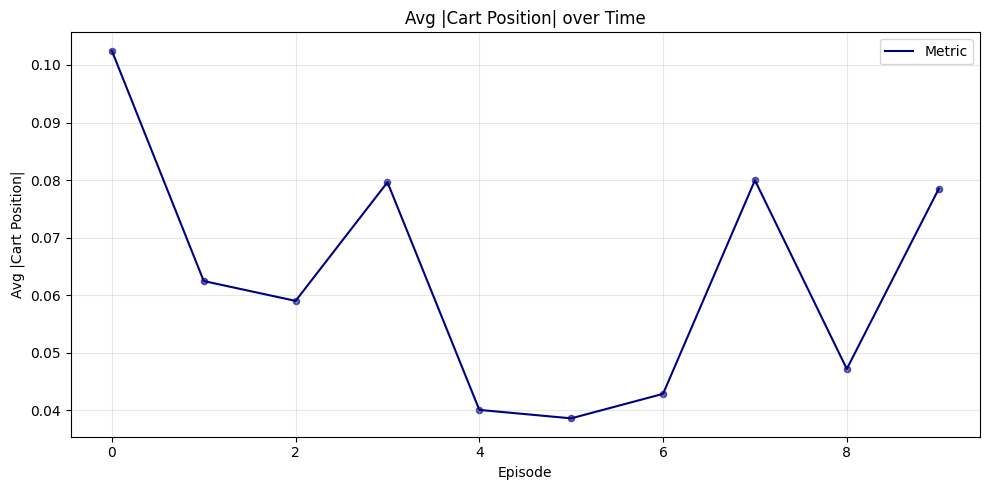

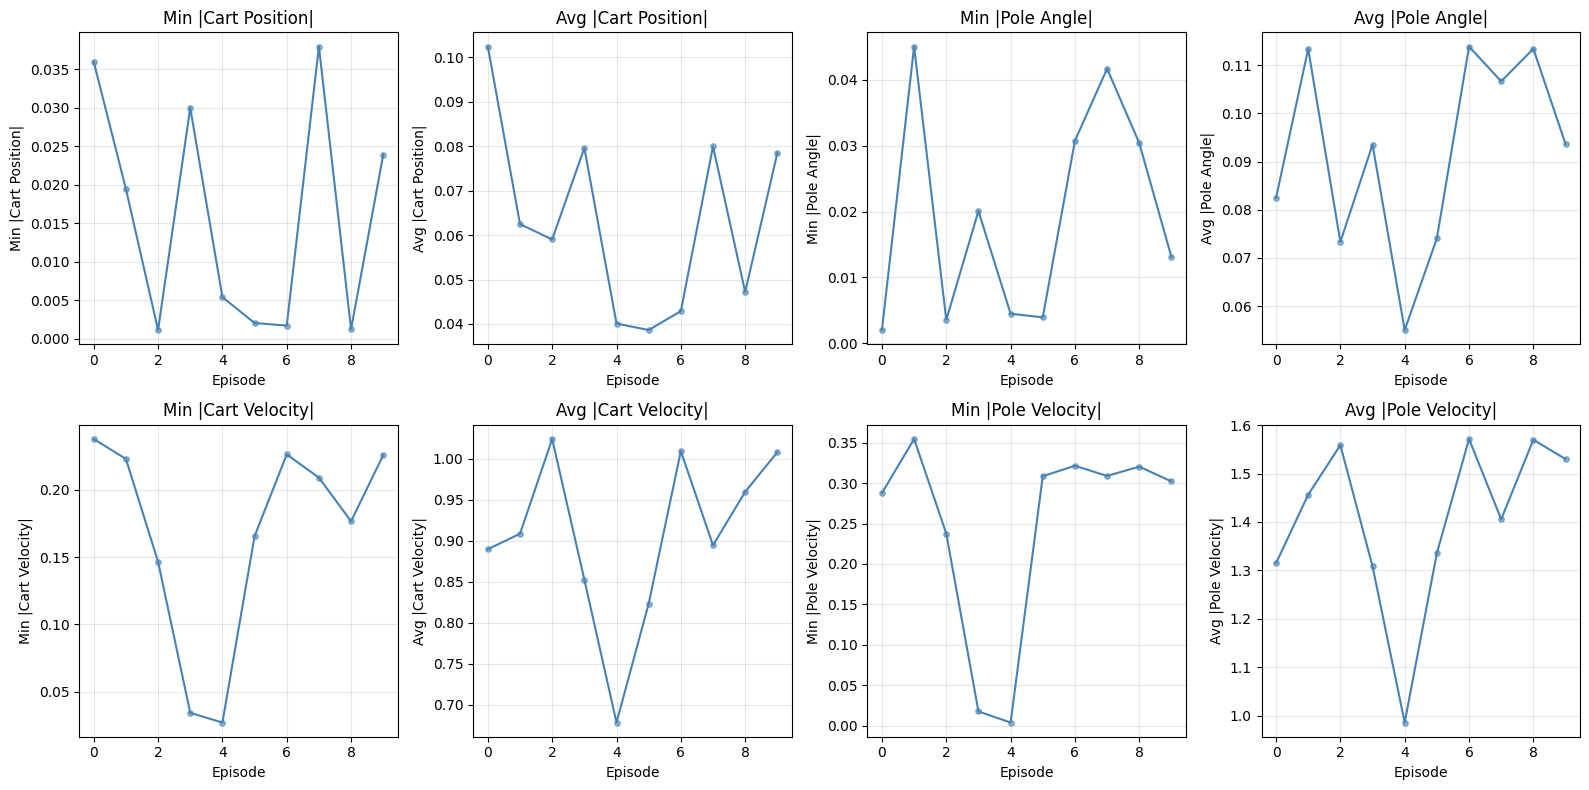

In [9]:

stats = compute_state_stats(episodes_states)


plot_state_metric(stats['best_x'], 'Max |Cart Position|', color='steelblue')
plot_state_metric(stats['avg_x'], 'Avg |Cart Position|', color='navy')


plot_state_metrics_all(stats)


Now that we have a baseline for our reinforcenet learning loop we can try training with our met network that will automatically shape our network.

In [10]:
inputs_dim = env.action_space.n + 2
meta_network_test, meta_memory = meta_network.build_model(inputs_dim)

In [ ]:
def training_loop_meta(episodes, epsilon_start=1.0, epsilon_end=0.05, epsilon_decay=0.995):
    total_reward_list = []
    epsilon = epsilon_start  # shared exploration schedule with baseline loop
    best_reward = 0
    actions = []
    for episode in range(episodes):
        state, _ = env.reset()
        processed_state = original_network.process_state(state)
        done = False
        total_reward = 0
        max_reward = -10

        frames = []
        while not done:

            action = original_network.select_action(processed_state, cartpole_network, device, epsilon,env)
            next_state, reward, terminated, truncated, _ = env.step(action)
            if (total_reward > 300):
                print(next_state)



            shaped_reward = meta_network.select_action(processed_state, action, reward, meta_network_test, device, epsilon, inputs_dim)
            actions.append(shaped_reward)

            done = terminated or truncated

            processed_next_state = original_network.process_state(next_state)

            memory.push(processed_state, action, (reward+shaped_reward), processed_next_state, done)
            

            processed_state = processed_next_state
            total_reward += reward
            
        


        original_network.optimize_model(cartpole_network, cartpole_target_network, memory, optimizer, device)
        
        meta_reward_data = meta_network.sliding_window(total_reward_list,50)
        meta_network_reward = meta_network.compute_reward(meta_reward_data)

        meta_state = np.append(processed_state, action)
        meta_memory.push(meta_state, shaped_reward, meta_network_reward, processed_next_state, True)
        meta_network.optimize_model(meta_network_test, meta_memory, device)
        
        if episode % TARGET_UPDATE == 0:
            cartpole_target_network.load_state_dict(cartpole_network.state_dict())

        if total_reward > best_reward:
            best_reward = total_reward
        
    
        print(f"Episode {episode+1}/{episodes}, Total Reward: {total_reward}")
        total_reward_list.append(total_reward)
        epsilon = max(epsilon_end, epsilon * epsilon_decay)

        
    return total_reward_list,actions

In [ ]:
_, action_list = training_loop_meta(1200)
plot_rewards(_)

Episode 1/1200, Total Reward: 49.0
Episode 2/1200, Total Reward: 59.0
Episode 3/1200, Total Reward: 39.0
Episode 4/1200, Total Reward: 38.0
Episode 5/1200, Total Reward: 44.0
Episode 6/1200, Total Reward: 40.0
Episode 7/1200, Total Reward: 113.0
Episode 8/1200, Total Reward: 80.0
Episode 9/1200, Total Reward: 72.0
Episode 10/1200, Total Reward: 76.0
Episode 11/1200, Total Reward: 60.0
Episode 12/1200, Total Reward: 67.0
Episode 13/1200, Total Reward: 76.0
Episode 14/1200, Total Reward: 57.0
Episode 15/1200, Total Reward: 45.0
Episode 16/1200, Total Reward: 88.0
Episode 17/1200, Total Reward: 40.0
Episode 18/1200, Total Reward: 78.0
Episode 19/1200, Total Reward: 66.0
Episode 20/1200, Total Reward: 105.0
Episode 21/1200, Total Reward: 62.0
Episode 22/1200, Total Reward: 52.0
Episode 23/1200, Total Reward: 46.0
Episode 24/1200, Total Reward: 40.0
Episode 25/1200, Total Reward: 80.0
Episode 26/1200, Total Reward: 34.0
Episode 27/1200, Total Reward: 48.0
Episode 28/1200, Total Reward: 60.0